<h1> Data Science Salaries Analysis </h1>

# Table of contents

- [Import Libraries](#Libraries)
- [Load dataset](#Dataset)
- [Dataset Analysis](#Analysis)
- [Unidimensional Analysis](#Unidimensional)
    * [Salary distribution](#Salary)
- [Bidimensional Analysis](#Bidimensional)
    * [Exchange rate](#Exchange)
    * [Salary comparation](#Salary)
    * [Top 10 job titles](#Toptitles)
    * [Remote ratio by work year](#Remote_vs_year)
    * [Experience level by company size](#Experiencec_vs_size)



## Libraries

Since it's a first test project on GitHub, the aim is to do an analysis of the dataset and the features, so only the necessary libraries are going to be implemented.

In [22]:
!pip install country_converter

# Basic data processing
import numpy as np 
import pandas as pd 
import country_converter as coco

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [2]:
ds = pd.read_csv('..//input/data-science-job-salaries/ds_salaries.csv',index_col=0)
ds.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


The columns of the dataset are, according to the data source, described as it follows:

  **work_year** : The year the salary was paid. 
  
  **experience_level:** The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director.
  
  **employment_type:** The type of employement for the role: PT Part-time FT Full-time CT Contract FL Freelance.
  
  **job_title:** The role worked in during the year.
  
  **employee_residence:** Employee's primary country of residence in during the work year as an ISO 3166 country code.
  
  **remote_ratio:** The overall amount of work done remotely, possible values are as follows: 0 No remote work (less than 20%) 50 Partially remote 100 Fully remote (more than 80%).
  
  **company_location:** The country of the employer's main office or contracting branch as an ISO 3166 country code.
  
  **company_size:** The average number of people that worked for the company during the year: S less than 50 employees (small) M 50 to 250 employees (medium) L more than 250 employees (large).

There are also one extra variable (divided in 3 due to the currency used) that could be considered the target a priori of the problem to analyze:

  **salary:** The total gross salary amount paid.
  
  **salary_currency:** The currency of the salary paid as an ISO 4217 currency code.
  
  **salary_in_usd:** The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com).

## Analysis

First we run a quick analysis on the dataset itself, to get its quality overall, and get a perspective of what's going to be the first step to process and interpret the data.

In [3]:
ds.info() # Show the title of the column, the dtype and the lenght of the dataset
ds.isnull().sum() # Adds information about the missing values to each of the columns
ds.describe() # Statistic approach to numerical variables of the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


,work_year,salary,salary_in_usd,remote_ratio
count,607.000000,6.070000e+02,607.000000,607.00000
mean,2021.405272,3.240001e+05,112297.869852,70.92257
std,0.692133,1.544357e+06,70957.259411,40.70913
min,2020.000000,4.000000e+03,2859.000000,0.00000
25%,2021.000000,7.000000e+04,62726.000000,50.00000
50%,2022.000000,1.150000e+05,101570.000000,100.00000
75%,2022.000000,1.650000e+05,150000.000000,100.00000
max,2022.000000,3.040000e+07,600000.000000,100.00000


Basic information about the dataset: there is a total of 607 individuals, which means that is a fairly small dataset and easy to cumpute. There are no missing values in any of the columns, so it is not necessary to address the problem of infering values or dropping whole columns, and there is a mix of numerical (only integers) and categorical variables to analyze.




In [4]:
#Change format to standarize the dataset describe() output
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Set 5 decimals to eliminate numerical notation
ds.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,607.00000,607.00000,607.00000,607.00000
mean,2021.40527,324000.06260,112297.86985,70.92257
std,0.69213,1544357.48664,70957.25941,40.70913
min,2020.00000,4000.00000,2859.00000,0.00000
25%,2021.00000,70000.00000,62726.00000,50.00000
50%,2022.00000,115000.00000,101570.00000,100.00000
75%,2022.00000,165000.00000,150000.00000,100.00000
max,2022.00000,30400000.00000,600000.00000,100.00000


According to this first approach it is possible to bring out the first conclussions for the numerical variables that will be analyzed in-depth in the following points. For example:

 * Since they're all integers, there are only 3 values for **work_year**: 2020, 2021, 2022. And since the mean is rounding 2021.4, we can assume that more than 50% of the salaries will be under the year 2022.

 * **Salary** and **salary_in_usd** are going to be tightly related, but since each country has a different conversion rate towards their domestic currency, it is clear comparing the interquartile interval of the salaries, the max and the min values and the standard deviation that it is a very unreliable distribution extremely affected by outliers. Nevertheless, the salary in USD, which a priori seems like a good standarization solution, has outliers in the min and the max range but it is much more robust.
 
 * The variable that evaluates the amount of remote work associated to each contract shows the dominance of the remote work (again over a 50%). Even thought this variable is given as the numerical type, it is best to treat it as a categorical one.

## Unidimensional

Analysis one by one of the categorical variables of the dataset. For basic visualization with barplots, boxplots, etc. the amount of values to be represented has been fixed to 10 or less, meaning that variables that exceed this value will have to be plotted in some other way

In [5]:
for col in ds.columns:
    if ds[col].value_counts().count()>10 and ds[col].dtype in ['object']:
        print('The amount of unique values for the variable {} is {}'.format(ds[col].name,ds[col].value_counts().count()))
        print()
# Obtain the categorical variables that have more than 10 unique values 

The amount of unique values for the variable job_title is 50

The amount of unique values for the variable salary_currency is 17

The amount of unique values for the variable employee_residence is 57

The amount of unique values for the variable company_location is 50



In [6]:
# Changing the country code to the ISO3 convention, which gives more intuitive information
converted_company_location = coco.convert(names=ds['company_location'], to="ISO3")
converted_employee_residence = coco.convert(names=ds['employee_residence'], to="ISO3")
ds['employee_residence'] = converted_employee_residence
ds['company_location'] = converted_company_location

# For visualization, only the 10 most frequent ocurrences are taken 
top_location = ds['company_location'].value_counts()[:10]
top_residence = ds['employee_residence'].value_counts()[:10]
top_titles = ds['job_title'].value_counts()[:10]

# Add description to the values of the rest of the categorical values
ds['experience_level'] = ds['experience_level'].replace('EN','Entry-level/Junior')
ds['experience_level'] = ds['experience_level'].replace('MI','Mid-level/Intermediate')
ds['experience_level'] = ds['experience_level'].replace('SE','Senior-level/Expert')
ds['experience_level'] = ds['experience_level'].replace('EX','Executive-level/Director')

ds['employment_type'] = ds['employment_type'].replace('FT','Full-time')
ds['employment_type'] = ds['employment_type'].replace('PT','Part-time')
ds['employment_type'] = ds['employment_type'].replace('CT','Contract')
ds['employment_type'] = ds['employment_type'].replace('FL','Freelance')

ds['company_size'] = ds['company_size'].replace('L','Large')
ds['company_size'] = ds['company_size'].replace('M','Medium')
ds['company_size'] = ds['company_size'].replace('S','Small')

ds['remote_ratio'] = ds['remote_ratio'].replace(0,'No remote')
ds['remote_ratio'] = ds['remote_ratio'].replace(50,'Partially remote')
ds['remote_ratio'] = ds['remote_ratio'].replace(100,'Fully remote')

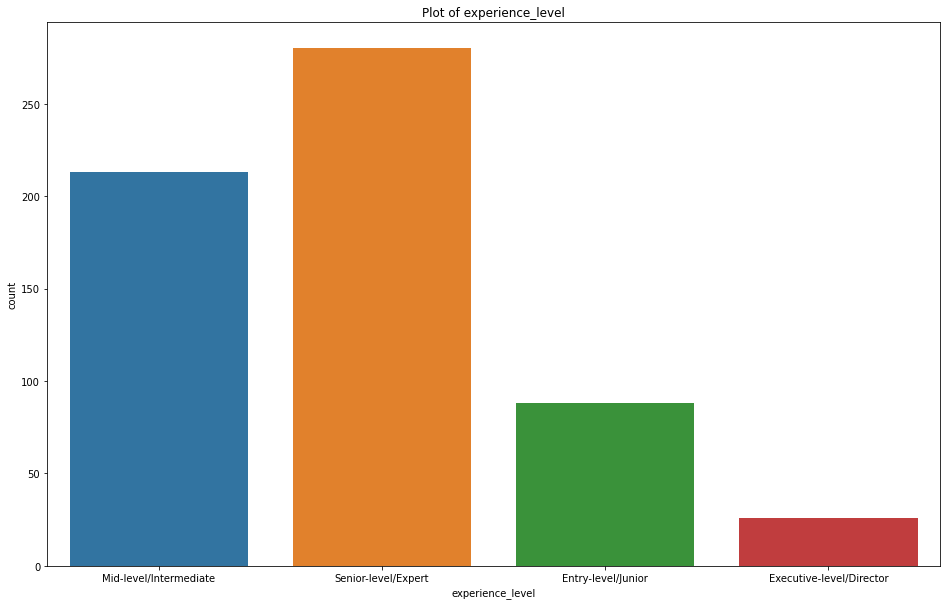

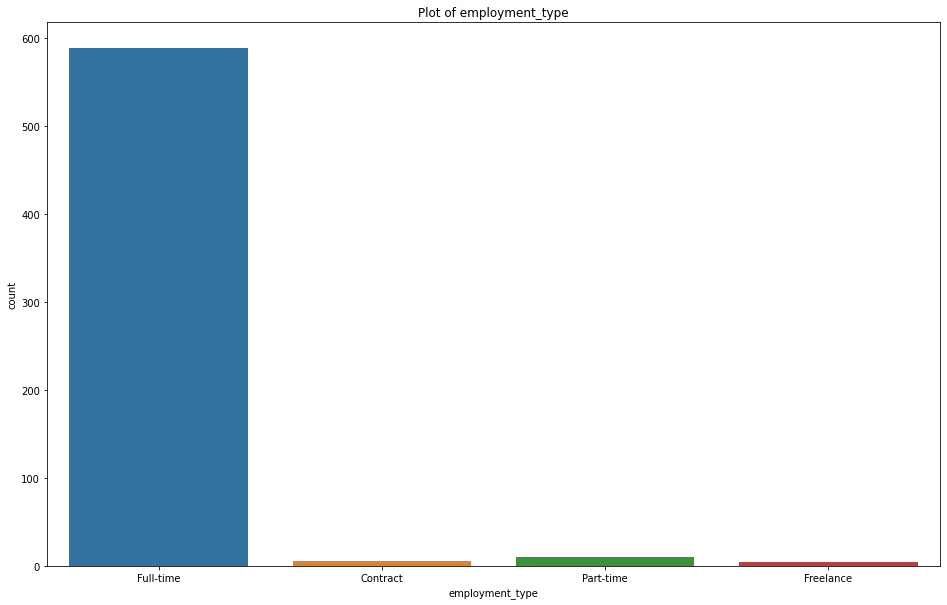

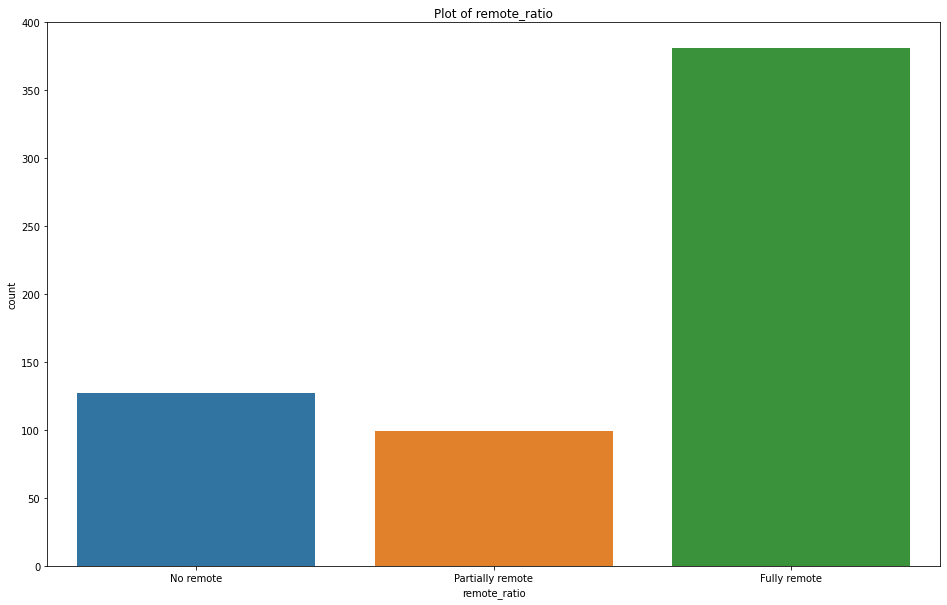

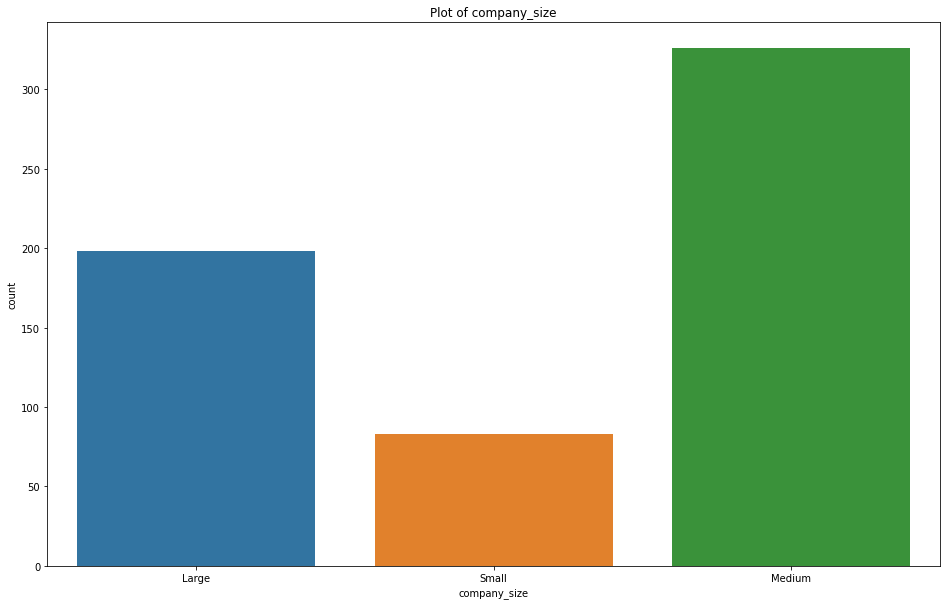

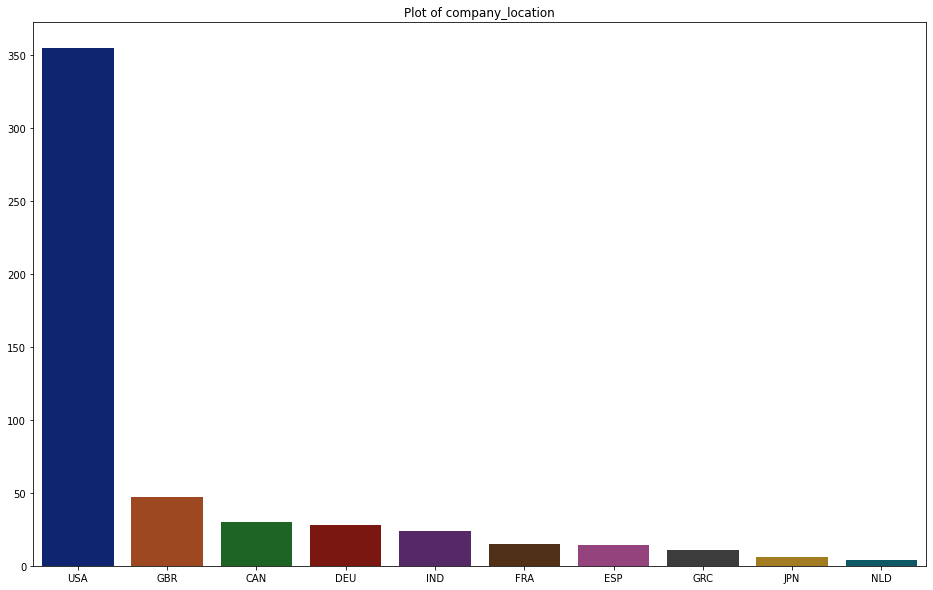

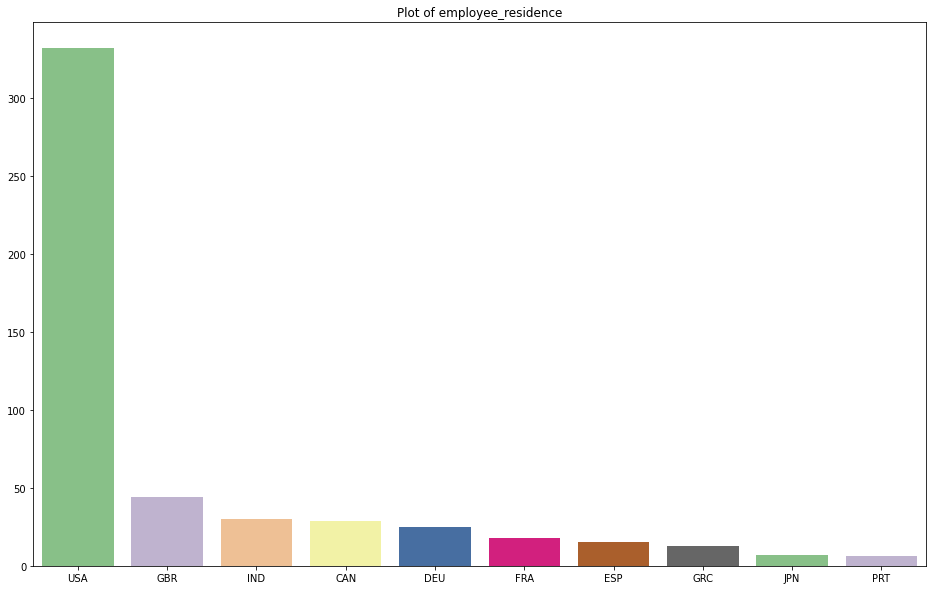

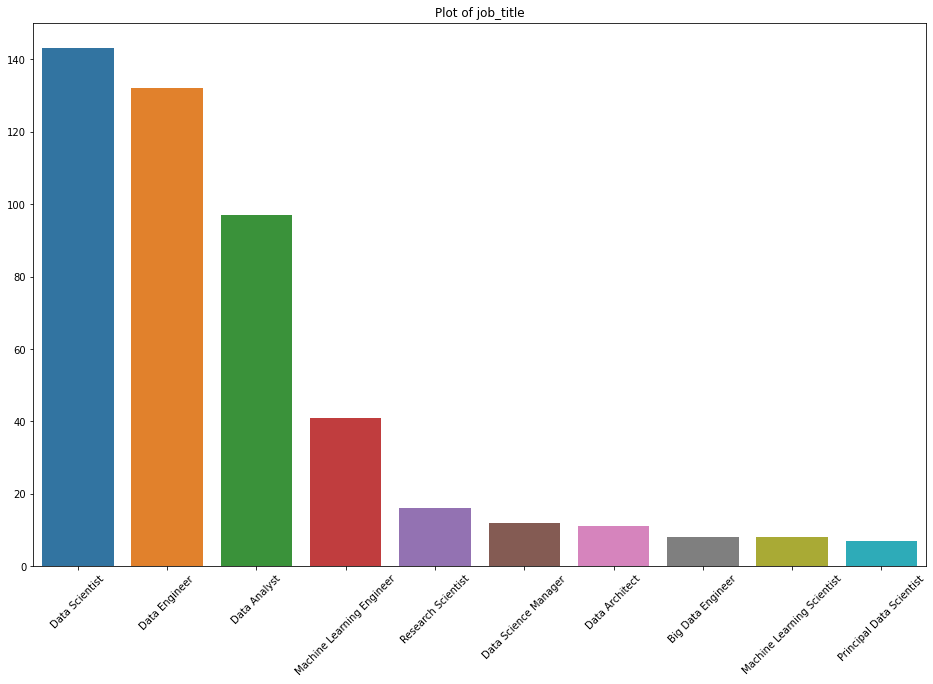

In [7]:
for col in ds.columns:
    if ds[col].dtype in ['object'] and ds[col].value_counts().count()<10:
        plt.figure(figsize=(16,10))
        ax = sns.countplot(data = ds, x = str(col)).set(title="Plot of {}".format(ds[col].name))
        plt.show()

plt.figure(figsize=(16,10))
sns.barplot(data = ds, x = top_location.index, y = top_location.values, palette='dark').set(title="Plot of {}".format(str(top_location.name)))
plt.show()

plt.figure(figsize=(16,10))
sns.barplot(data = ds, x = top_residence.index, y = top_residence.values,palette='Accent').set(title="Plot of {}".format(str(top_residence.name)))
plt.show()

plt.figure(figsize=(16,10))
sns.barplot(data = ds, x = top_titles.index, y = top_titles.values).set(title="Plot of {}".format(str(top_titles.name)))
plt.xticks(rotation=45)
plt.show()


It is very noticeable that:

* The minority of the experience level is executive or director.
* The huge majority of the type of contracts (over 90%) correspond to the Full Time kind.
* There is a predominance of full remote contracts in the **remote_ratio** variable and of workers in Medium size companies in **company_size**
* The countries in **company_location** and **employee_residence** are very similar, indicating that most likely the full remote worker (the majority) works in the same country that is hired. Most of the companies and the individuals are located in just one country.

### Salary 

Coming back to numerical variables, the last analyzed salary, it's distributed in the following graph

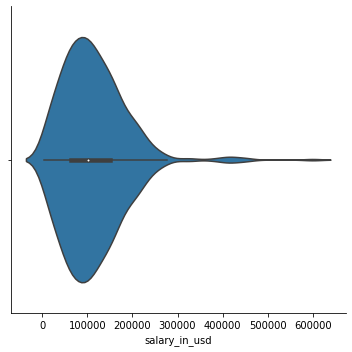

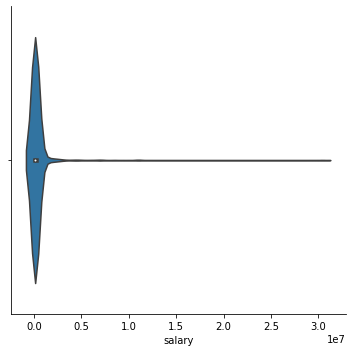

In [8]:
sns.catplot(data=ds,x='salary_in_usd',kind='violin')
sns.catplot(data=ds,x='salary',kind='violin')
plt.show()

As concluded in the first point, the salary in USD has similarities to a normal distribution whereas the salary in each of the respective domestic currencies of the countries is not a very practical variable to analyze. 


## Bidimensional

### Exchange 

In addition, the little feature engineering that is going to be made in this project is just to find out how the exchange between this two variables was made:

In [9]:
ds.salary_currency.value_counts()

USD    398
EUR     95
GBP     44
INR     27
CAD     18
JPY      3
PLN      3
TRY      3
CNY      2
MXN      2
HUF      2
DKK      2
SGD      2
BRL      2
AUD      2
CLP      1
CHF      1
Name: salary_currency, dtype: int64

Apart from the obvious abundance of the USD, the fourth first currencies represent over 95% of the salaries

In [10]:
ds['change_rate']=ds['salary'].astype(float)/ds['salary_in_usd'].astype(float) 
# Remove the reference currency and the two that have just one data point
for row in [x for x in ds.salary_currency.unique() if x != 'USD' and x!= 'CHF' and x!= 'CLP']:
    print(row)
    print(ds[['work_year','change_rate']].loc[ds.salary_currency==row])
    print()

EUR
     work_year  change_rate
0         2020      0.87683
10        2020      0.87683
12        2020      0.87684
17        2020      0.87683
22        2020      0.87685
..         ...          ...
500       2022      0.90980
501       2022      0.90981
507       2022      0.90981
513       2022      0.90980
517       2022      0.90980

[95 rows x 2 columns]

GBP
     work_year  change_rate
2         2020      0.77964
44        2020      0.77964
46        2020      0.77965
72        2021      0.72703
105       2021      0.72703
111       2021      0.72703
112       2021      0.72703
123       2021      0.72703
171       2021      0.72703
183       2021      0.72703
212       2021      0.72703
221       2021      0.72703
223       2021      0.72703
245       2021      0.72703
248       2021      0.72703
300       2022      0.76408
301       2022      0.76407
304       2022      0.76407
311       2022      0.76408
312       2022      0.76408
313       2022      0.76408
314       2022  

The **change_rate** had to be necessarily defined as the float type, but since the result is the division between two integers, similar values of **change_rate** could actually be the same value since the int64 type carries the rounding error. Since the salaries are oscilating within orders of magnitude of 10^4-5, it is safe to assume that the error would be the inverse: 10^(-4-5).

Following this reasoning, the currency with the highest representation besides the USD is the EUR, and its value shows an oscilation of around 0.03, which is 100 to 1000 times superior to the error expected with the approximation made. This can only mean that different actual currency rates were used for each one of the years. The rates within each of the years is pretty much constant.

### Salary

Analysis of the salary in USD for each of the variables

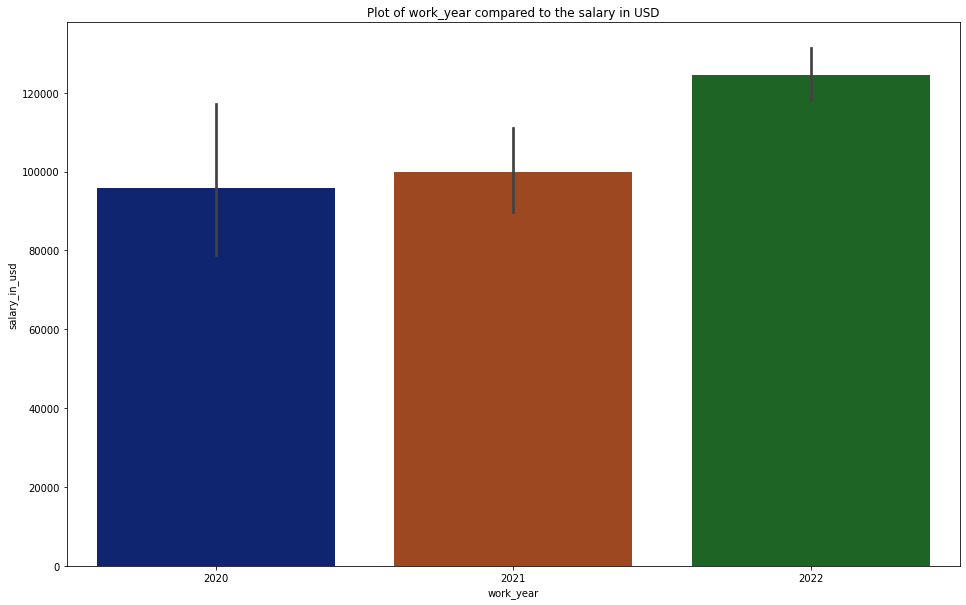

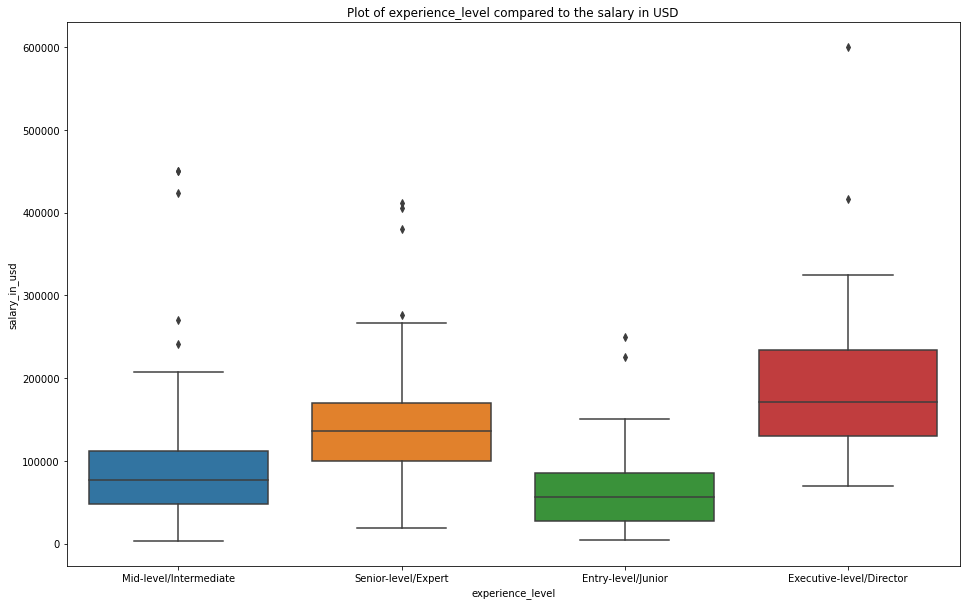

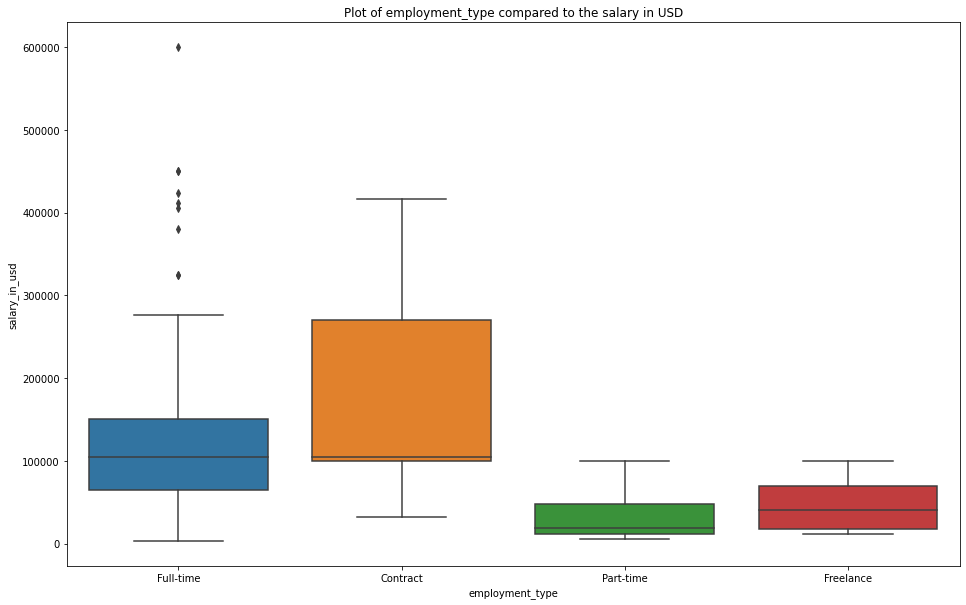

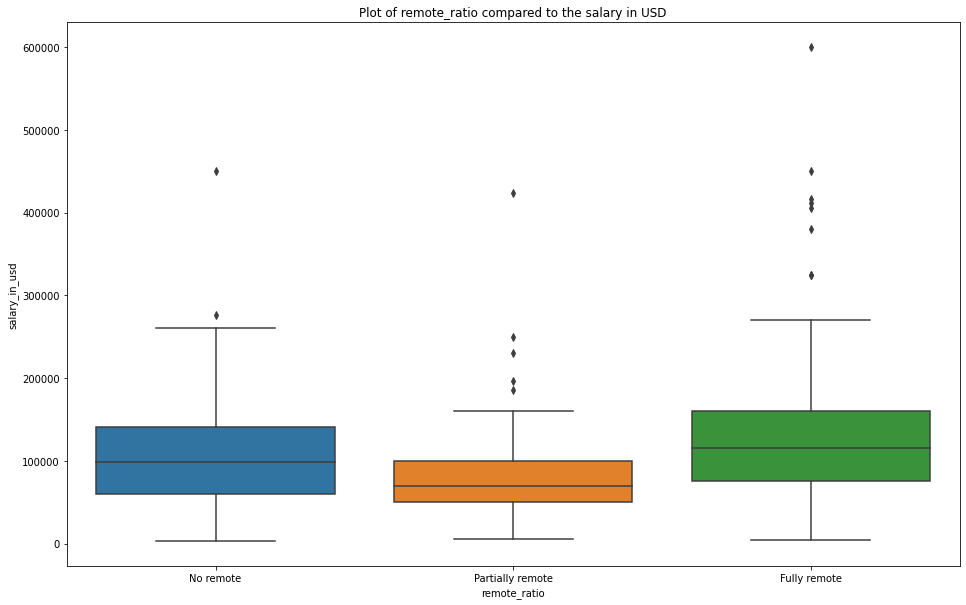

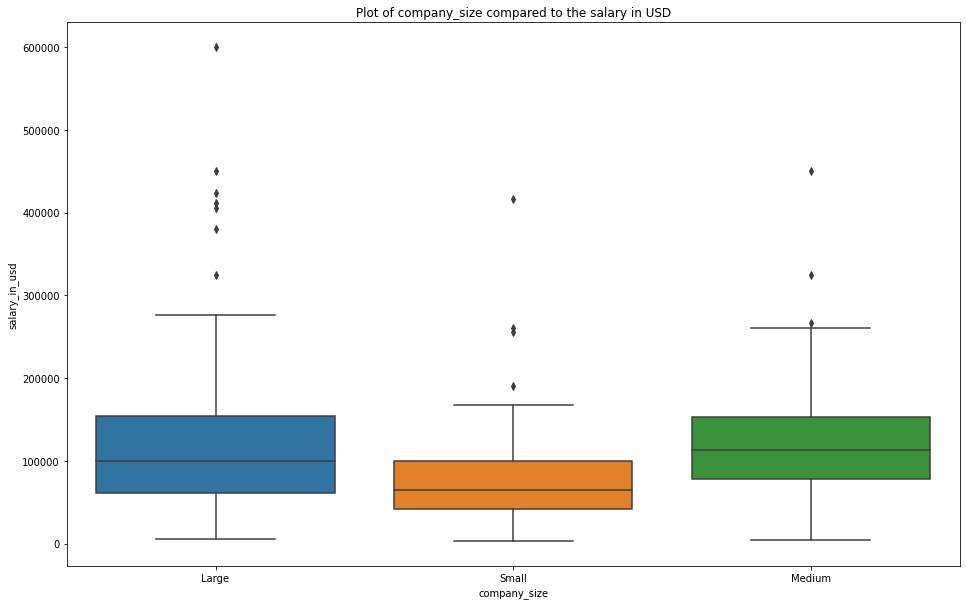

In [11]:
# Iterating through all the dataset
for col in [x for x in ds.columns if x!='salary_in_usd' and x!='salary']:
    if ds[col].value_counts().count()<10:
        plt.figure(figsize=(16,10))
        if ds[col].dtype in ['int64']:
            sns.barplot(data = ds, x = str(col), y = "salary_in_usd", palette='dark').set(title="Plot of {} compared to the salary in USD".format(str(col)))
            plt.show()
        elif ds[col].dtype in ['object']:
            sns.boxplot(data = ds, x = str(col), y = "salary_in_usd").set(title="Plot of {} compared to the salary in USD".format(str(col)))
            plt.show()

The analysis of the influence over the salary brings some conclusions:
* The salary increases each year, which is expected.
* The salary progresses with experience unsurprisingly, with several outliers exagerated specially in the *Mid-Level/Intermediate* and the *Executive-Level/Director*.
* The employment type is still not very representative since it is already known that over 95% of the data points are concentrated in the *Full-Time* category.
* The *Fully remote* employees have also the highest representation amongst the 3 categories and thus they cover a wider range of salaries.
* Employees in *Small* size companies are underpaid compared to *Medium* and *Large* companies, where the difference is not that relevant.

The next barplots are focused on the categorical variables that had a lot of unique values:

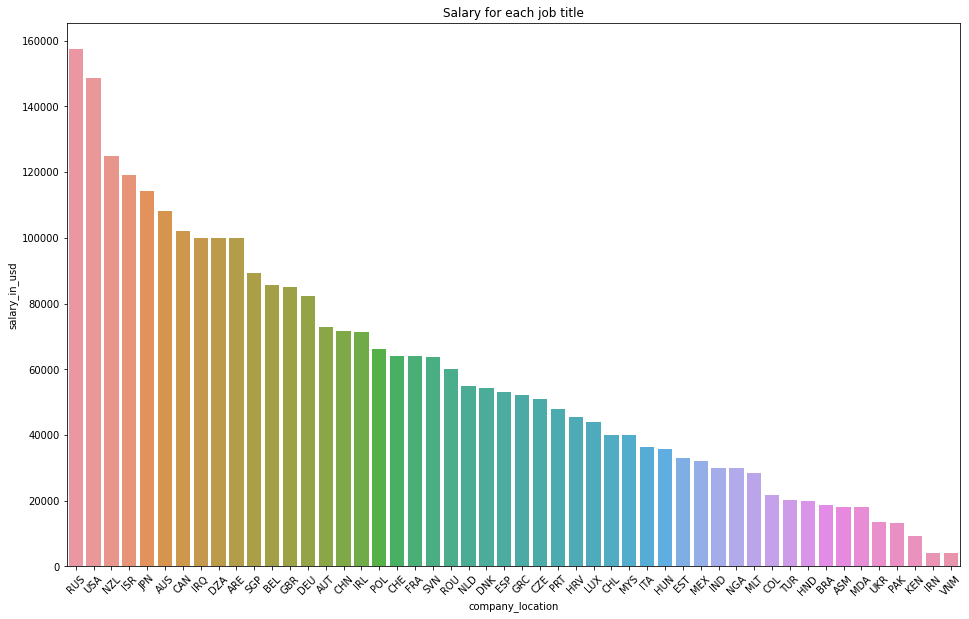

In [12]:
salary_location = ds.groupby(['salary_in_usd','company_location']).size().reset_index()
average_sl = salary_location.groupby('company_location',sort=False).mean().reset_index().sort_values(by=['salary_in_usd'],ascending=False)

plt.figure(figsize=(16,10))
sns.barplot(data = average_sl, x = 'company_location', y = 'salary_in_usd').set(title="Salary for each job title" )
plt.xticks(rotation=45)
plt.show()

The distribution of average salaries in USD by country shows a very obvious conclusion, that is that the salary has a high correlation with the cost of living and the geopolitical context of each of the countries: higher salaries on high GDP countries like Japan, Russia, North American, Oceania and European states and lower salaries on lower GDP countries such as Asian and African states, or even conflictive states like Ukraine (war) or Turkey (economy crysis).

### Toptitles

Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                            

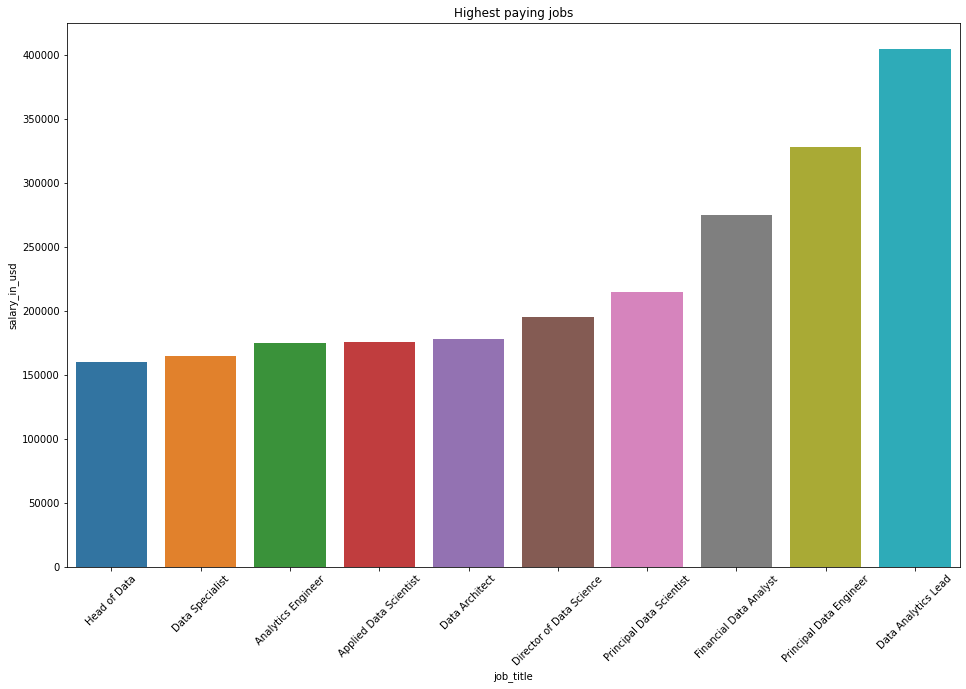

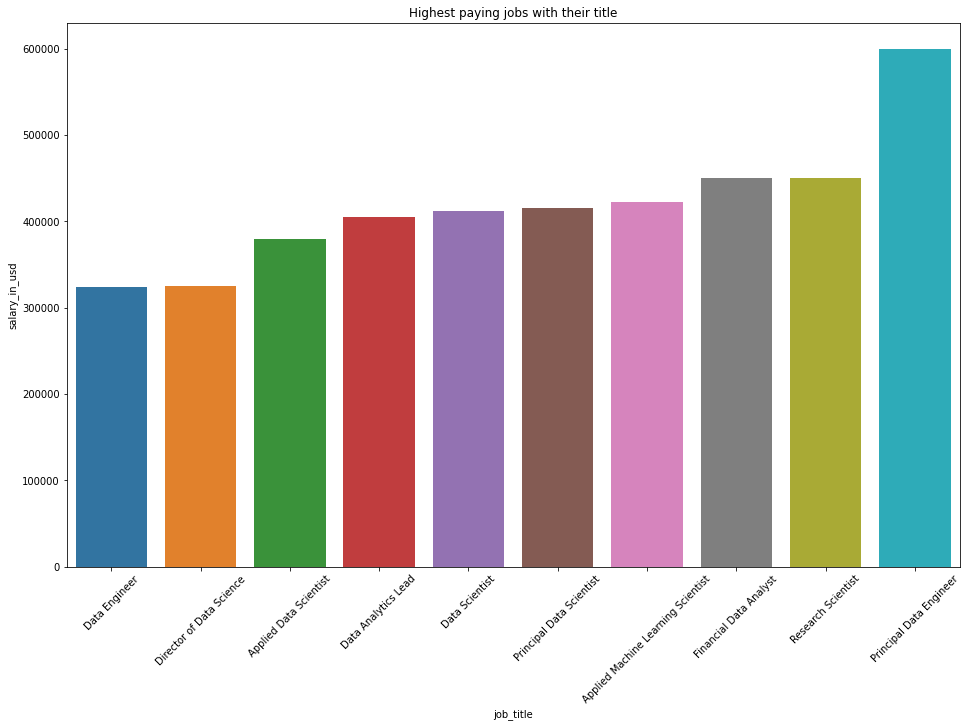

In [13]:
#the 10 highest paying jobs and their roles
salary_job = ds.groupby(['salary_in_usd','job_title']).size().reset_index()
average_sj = salary_job.groupby('job_title',sort=False).mean().reset_index().sort_values(by=['salary_in_usd'])
print(ds['job_title'].value_counts())

# Since the biggest majority of individuals is concentrated in a few titles, only the top 10 are shown
plt.figure(figsize=(16,10))
sns.barplot(data = average_sj[-10:], x = 'job_title', y = 'salary_in_usd').set(title="Highest paying jobs" )
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(16,10))
sns.barplot(data = salary_job[-10:], x = 'job_title', y = 'salary_in_usd').set(title="Highest paying jobs with their title" )
plt.xticks(rotation=45)
plt.show()

It has been shown the count of unique values of the titles of the jobs related to the Data Science industry because the charts show which are the roles of the individuals that are getting the highest salary and which is the job title that in average has a higher salary. This might be biased because also the lowest paying jobs could be analyzed, but they are more likely to be populated by the predominant roles on an *Entry-level/Junior* experience level whereas the highest paying individuals have jobs that are very infrequent. In fact, there is only one role among the 10 highest payed (*Data Architect*) that is occupied by 10 or more individuals.

### Remote_vs_year

Since in 2020 the protagonist was a pandemic caused by the virus COVID-19, most employees working in Data Science and other IT roles had to switch to fully remote or hybrid work contracts. Even when it was declared to be safe to go back to the offices, a relevant group of workers embraced the remote work culture, so not necessarily these contracts had to disappear in 2022.

<Figure size 1152x720 with 0 Axes>

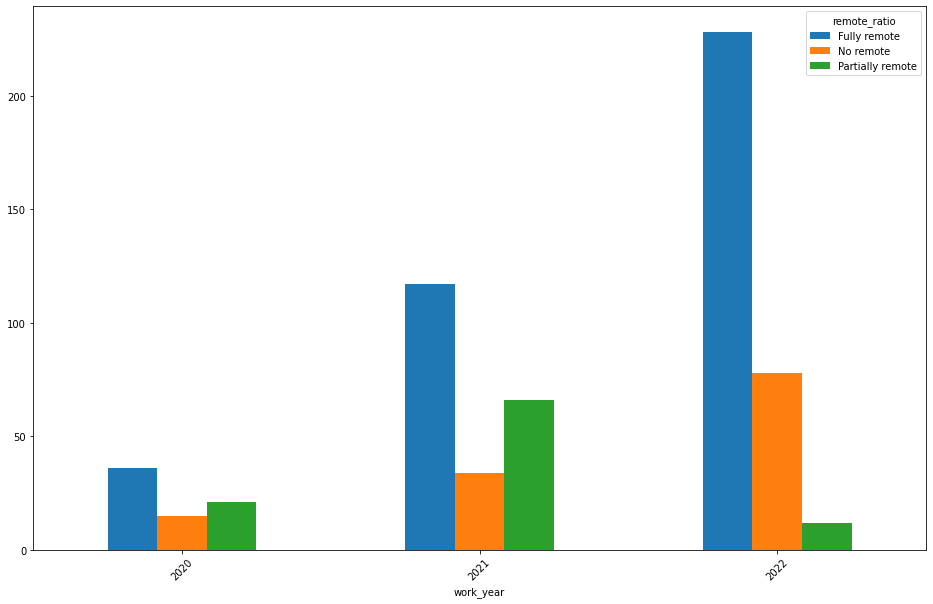

In [14]:
plt.figure(figsize=(16,10))
ds.groupby(['work_year','remote_ratio']).size().unstack().plot.bar(figsize=(16,10))
plt.xticks(rotation=45)
plt.show()

As shown in the first point, the representation of the contracts during 2020 is much lower than 2021 and 2022, specially this last one. Nevertheless, it can be concluded that the average worker in Data Science embraced and accepted the fully remote work and at the same time others decide to go back to work presentially, leaving a drastic diminution only in the partially remote work.

### Experience_vs_size

The concentration of the employees on companies of different size depending on their level of experience could be also interesting:

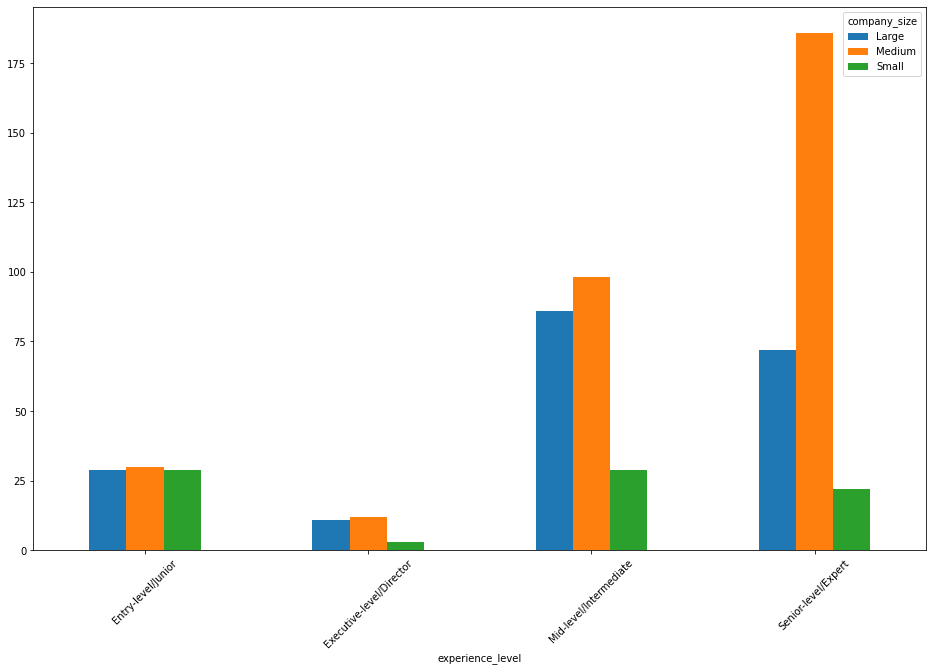

In [15]:
ds.groupby(['experience_level','company_size']).size().unstack().plot.bar(figsize=(16,10))
plt.xticks(rotation=45)
plt.show()

The small companies seem to have a more reduced Data Science team since for each *Entry-Level/Junior* employee they have fewer more experienced colleagues. On the contrary, the rest have a much bigger team formed by more experienced people, specially the *Medium* size companies with *Senior-level/Expert*.

Note: This dataset is actually very reduced and does not offer any information about the origin of each of the individuals, so this conclusion might be a bit bold and inaccurate.